In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

### Data Initialization:

In [2]:
# Real data on memory task
num_trials = 20
data = np.array([8, 2, 1, 7]) # true positive, false positive, false negative, true negative
# TP (old -> old), FP (new -> old), FN (old -> new), TN (new -> new)
pd.DataFrame(data[:, None].T, columns=['TP', 'FP', 'FN', 'TN'], index=['responses'])

,TP,FP,FN,TN
responses,8,2,1,7


### One-high-threshold (1HT) MPT model:

In [5]:
one_mpt_model_code = """
data {
  int<lower=1> N; // Number of trials
  int<lower=1> K; // Number of categories
  array[K] int<lower=0, upper=N> freqs;
}

parameters {
  real<lower=0, upper=1> d;
  real<lower=0, upper=1> g;
}

transformed parameters {
  simplex[K] theta; // assume equal chance for either an old item or new item
  theta[1] = 0.5 * d + 0.5 * (1 - d) * g; // Prob. True Positive
  theta[2] = 0.5 * g; // Prob. False Positive
  theta[3] = 0.5 * (1 - d) * (1 - g); // False Negative
  theta[4] = 0.5 * (1 - g); // Prob. True Negative
}

model {
  //Prior
  target += beta_lpdf(d | 1, 1);
  target += beta_lpdf(g | 1, 1);

  //Likelihood
  target += multinomial_lpmf(freqs | theta);
}

generated quantities{
  // Predictions of frequencies go here
  array[K] int preds = multinomial_rng(theta, N);
}
"""

In [6]:
# Prepare data
stan_dict = {
    'freqs': data,
    'N': num_trials,
    'K': data.shape[0]
}

# Compile model
posterior = stan.build(one_mpt_model_code, data=stan_dict, random_seed=42)

# Sample (i.e., inverse inference)
fit = posterior.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Building...



Building: 27.2s, done.Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 2.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!


In [7]:
# Parameter recovery and predictions
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d,0.732,0.172,0.409,0.984,0.002,0.002,6570.0,5154.0,1.0
g,0.296,0.136,0.063,0.550,0.002,0.001,5548.0,5605.0,1.0
theta[0],0.409,0.054,0.309,0.494,0.001,0.000,8465.0,7265.0,1.0
theta[1],0.148,0.068,0.032,0.275,0.001,0.001,5548.0,5605.0,1.0
theta[2],0.091,0.054,0.006,0.191,0.001,0.000,8465.0,7265.0,1.0
theta[3],0.352,0.068,0.225,0.468,0.001,0.001,5548.0,5605.0,1.0
preds[0],8.226,2.442,3.000,12.000,0.025,0.018,9626.0,9289.0,1.0
preds[1],2.957,2.050,0.000,7.000,0.023,0.016,7688.0,8750.0,1.0
preds[2],1.822,1.669,0.000,5.000,0.017,0.012,9188.0,9294.0,1.0
preds[3],6.995,2.508,2.000,11.000,0.027,0.019,8508.0,9587.0,1.0


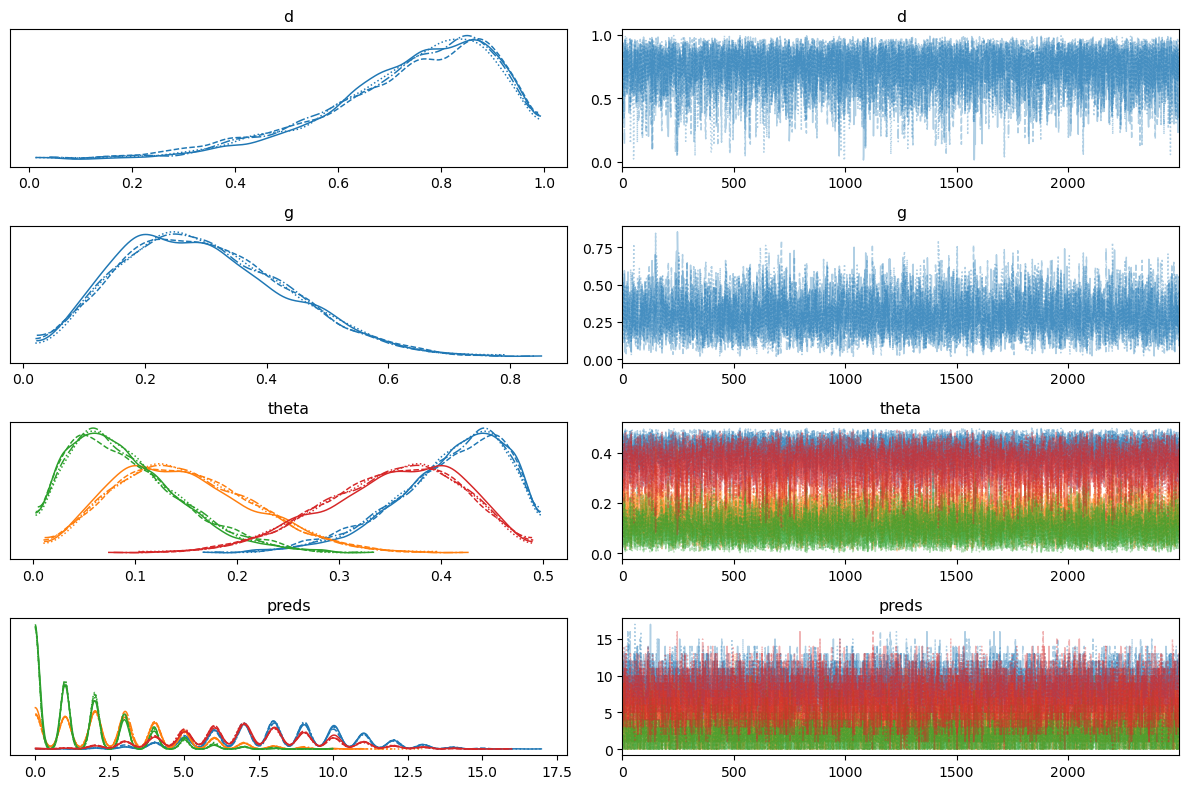

In [8]:
# Traceplots and marginals - visual convergence checks
axarr = az.plot_trace(fit)
plt.tight_layout()

#### Results of 1HT MPT Model:
We see that the model converges because r_hat is 1.0 and it is efficient because the efficiency diagnostic (ess) is less than 10000 (num_samples * num_chains).

The model predicts that d is about 0.732 and g is about 0.296. These parameters give a good prediction for the true data. We see that the model predicts the true positives to be about 8.226 while the actual value is 8. It predicts the false positives to be about 2.957 while the actual value is 2. It predicts the false negatives to be about 1.822 while the actual value is 1. Lastly, the model predicts the true negatives to be about 6.995 while the actual value is 7.

### Two-high-threshold (2HT) MPT model:

In [9]:
two_mpt_model_code = """
data {
  int<lower=1> N; // Number of trials
  int<lower=1> K; // Number of categories
  array[K] int<lower=0, upper=N> freqs;
}

parameters {
  real<lower=0, upper=1> d;
  real<lower=0, upper=1> g;
}

transformed parameters {
  simplex[K] theta; // assume equal chance for either an old item or new item
  theta[1] = 0.5 * d + 0.5 * (1 - d) * g; // Prob. True Positive
  theta[2] = 0.5 * (1 - d) * g; // Prob. False Positive
  theta[3] = 0.5 * (1 - d) * (1 - g); // False Negative
  theta[4] = 0.5 * d + 0.5 * (1 - d) * (1 - g); // Prob. True Negative
}

model {
  //Prior
  target += beta_lpdf(d | 1, 1);
  target += beta_lpdf(g | 1, 1);

  //Likelihood
  target += multinomial_lpmf(freqs | theta);
}

generated quantities{
  // Predictions of frequencies go here
  array[K] int preds = multinomial_rng(theta, N);
}
"""

In [11]:
# Prepare data
stan_dict = {
    'freqs': data,
    'N': num_trials,
    'K': data.shape[0]
}

# Compile model
posterior = stan.build(two_mpt_model_code, data=stan_dict, random_seed=42)

# Sample (i.e., inverse inference)
fit = posterior.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Building...



Building: 28.4s, done.Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!


In [12]:
# Parameter recovery and predictions
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d,0.619,0.159,0.317,0.895,0.002,0.001,6284.0,5201.0,1.0
g,0.604,0.190,0.266,0.947,0.002,0.002,7814.0,5523.0,1.0
theta[0],0.424,0.050,0.334,0.498,0.001,0.000,6825.0,5965.0,1.0
theta[1],0.115,0.060,0.015,0.223,0.001,0.001,6927.0,5818.0,1.0
theta[2],0.076,0.050,0.002,0.166,0.001,0.000,6825.0,5965.0,1.0
theta[3],0.385,0.060,0.277,0.485,0.001,0.001,6927.0,5818.0,1.0
preds[0],8.518,2.392,3.000,12.000,0.025,0.017,9386.0,9550.0,1.0
preds[1],2.302,1.857,0.000,6.000,0.020,0.014,8400.0,8663.0,1.0
preds[2],1.515,1.549,0.000,4.000,0.017,0.012,8167.0,8478.0,1.0
preds[3],7.665,2.466,3.000,12.000,0.026,0.019,8812.0,8822.0,1.0


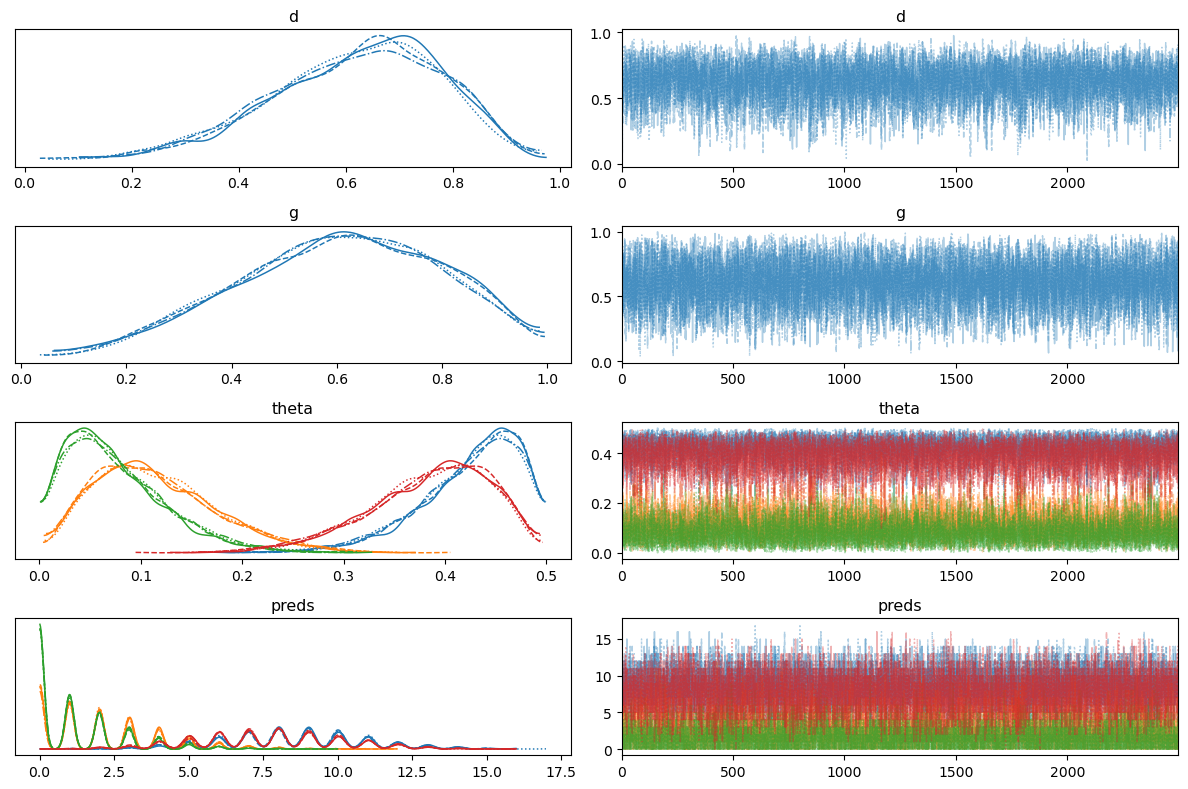

In [13]:
# Traceplots and marginals - visual convergence checks
axarr = az.plot_trace(fit)
plt.tight_layout()

#### Results of 2HT MPT Model:
We see that the model converges because r_hat is 1.0 and it is efficient because the efficiency diagnostic (ess) is less than 10000 (num_samples * num_chains).

The model predicts that d is about 0.619 and g is about 0.604. These parameters give a good prediction for the true data. We see that the model predicts the true positives to be about 8.518 while the actual value is 8. It predicts the false positives to be about 2.302 while the actual value is 2. It predicts the false negatives to be about 1.515 while the actual value is 1. Lastly, the model predicts the true negatives to be about 7.665 while the actual value is 7.

### Overall Results:
The two models suggest different estimates for the two key parameters. However, both models also give a good prediction for the true data, although there are some slight differences. It seems that the 1HT MPT model does better at predicting the true positives and true negatives, while the 2HT model does better at predicting the false positives and false negatives.